https://en.wikipedia.org/wiki/Fibonacci_word_fractal

Prompt: generate Fibonacci word fractal code (reference: https://en.wikipedia.org/wiki/Fibonacci_word_fractal) and plots, also generate code to look at the fractal dimension and show this as part of the output

### ------------------ Parameters ------------------

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# ------------------ Parameters ------------------
ORDER = 20           # Fibonacci word order (e.g., 18–22 are reasonable; too big -> heavy)
STEP  = 1.0          # Step length (kept at 1.0; scaling doesn't change dimension)
ANGLE_DEG = 90.0     # Turning angle (Fibonacci word fractal uses 90°)

### ------------------ Fibonacci word ------------------

In [16]:
# ------------------ Fibonacci word ------------------
def fibonacci_word(n: int) -> str:
    """
    Returns the nth Fibonacci word using concatenation:
      F1 = "1", F2 = "0", Fn = F(n-1) + F(n-2).
    The infinite limit begins 0100101001001...
    """
    if n == 0:
        return "0"
    if n == 1:
        return "01"
    a, b = "0", "01"
    for _ in range(2, n+1):
        a, b = b, b + a
    return b


f = fibonacci_word(10)
print(f"Fibonacci word of order {ORDER}: {f}")

Fibonacci word of order 20: 010010100100101001010010010100100101001010010010100101001001010010010100101001001010010010100101001001010010100100101001001010010100100101001010


### ------------------ Build polyline by odd-even drawing rule ------------------

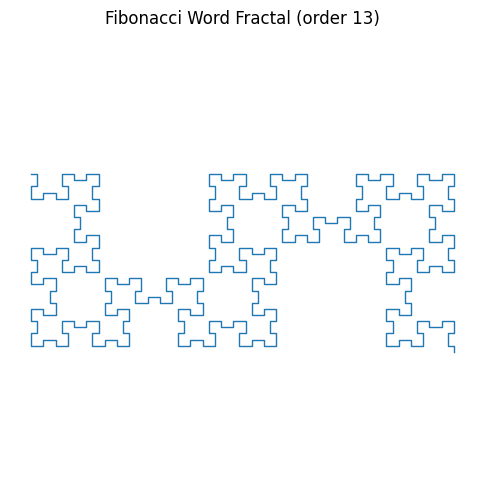

In [29]:
# ------------------ Build polyline by odd-even drawing rule ------------------
def fib_word_curve(word: str, step: float = 1.0, angle_deg: float = 90.0):
    """Apply Odd–Even Drawing Rule to generate curve points from Fibonacci word."""
    theta = 0.0   # heading (radians), initial facing east
    x, y = 0.0, 0.0
    pts = [(x, y)]
    ang = np.deg2rad(angle_deg)

    for k, ch in enumerate(word, start=1):
        # Step forward
        x += step * np.cos(theta)
        y += step * np.sin(theta)
        pts.append((x, y))

        # Apply turning rule if digit is 0
        if ch == "0":
            if k % 2 == 0:   # even
                theta += ang   # left
            else:             # odd
                theta -= ang   # right
        # If ch == "1": no turn

    return np.array(pts)

# Example: draw curve for order 13
n = 13
word = fibonacci_word(n)
pts = fib_word_curve(word)

plt.figure(figsize=(6,6))
plt.plot(pts[:,0], pts[:,1], linewidth=1)
plt.axis("equal"); plt.axis("off")
plt.title(f"Fibonacci Word Fractal (order {n})")
plt.show()

### ------------------ Box-counting on sampled points ------------------

In [30]:
# ------------------ Box-counting on sampled points ------------------
import numpy as np

def box_count_dimension(points: np.ndarray,
                        scales: str = "powers_of_two",
                        min_boxes: int = 6,
                        drop_edges: int = 2):
    """
    Estimate the box-counting (Minkowski–Bouligand) dimension of a 2D set.

    Parameters
    ----------
    points : (N, 2) array-like
        2D coordinates (e.g., vertices of the Fibonacci-word curve).
        They can be real-valued; we normalize/quantize internally.
    scales : {'powers_of_two', 'auto'}
        - 'powers_of_two': use ε = 1, 2, 4, 8, ...
        - 'auto': use ~log-spaced ε between pixel 1 and span.
    min_boxes : int
        Require at least this many distinct scales (after trimming) for regression.
    drop_edges : int
        Trim this many smallest and largest scales before fitting, to reduce
        finite-size and saturation bias.

    Returns
    -------
    result : dict with keys
        'D'          : slope of log N(ε) vs log(1/ε) (the dimension estimate)
        'eps'        : array of ε (box sizes, in pixel units)
        'N_eps'      : occupied box counts at each ε
        'xlog'       : log(1/ε)
        'ylog'       : log N(ε)
        'fit_slice'  : slice used for the linear fit
        'intercept'  : intercept of the fitted line
    """
    pts = np.asarray(points, dtype=float)
    if pts.ndim != 2 or pts.shape[1] != 2:
        raise ValueError("points must be an (N,2) array")

    # Translate so min corner is at (0,0), then quantize to integer pixel grid
    x = pts[:, 0]; y = pts[:, 1]
    X = np.rint(x - x.min()).astype(np.int64)
    Y = np.rint(y - y.min()).astype(np.int64)

    # Span (in pixels)
    width  = int(X.max() - X.min() + 1)
    height = int(Y.max() - Y.min() + 1)
    L = max(width, height)
    if L <= 1:
        return {'D': 0.0, 'eps': np.array([1.0]), 'N_eps': np.array([1.0]),
                'xlog': np.array([0.0]), 'ylog': np.array([0.0]),
                'fit_slice': slice(0,1), 'intercept': 0.0}

    # Choose box sizes ε
    if scales == "powers_of_two":
        max_pow = int(np.floor(np.log2(L)))
        eps = 2 ** np.arange(0, max_pow + 1, dtype=int)
    else:  # 'auto' ~log-spaced integer eps between 1 and L
        k = max(8, int(np.ceil(np.log2(L)) + 1))  # ensure enough samples
        eps = np.unique(np.clip(np.rint(np.geomspace(1, L, k)), 1, L).astype(int))

    # Count occupied boxes for each ε
    N_eps = []
    for e in eps:
        i = X // e
        j = Y // e
        # unique (i,j) pairs via hashing
        key = i * (L + 1) + j
        N_eps.append(np.unique(key).size)
    N_eps = np.asarray(N_eps, dtype=float)

    # Prepare regression: log N vs log(1/ε)
    xlog = np.log(1.0 / eps.astype(float))
    ylog = np.log(N_eps)

    # Trim edges to mitigate bias (coarsest: saturation; finest: discretization)
    if len(eps) > 2 * drop_edges:
        sl = slice(drop_edges, len(eps) - drop_edges)
    else:
        sl = slice(0, len(eps))

    if (sl.stop - sl.start) < min_boxes:
        # fall back: no trimming
        sl = slice(0, len(eps))

    # Linear fit
    slope, intercept = np.polyfit(xlog[sl], ylog[sl], 1)

    return {
        'D': float(slope),
        'eps': eps.astype(float),
        'N_eps': N_eps,
        'xlog': xlog,
        'ylog': ylog,
        'fit_slice': sl,
        'intercept': float(intercept),
    }

n = 7

word = fibonacci_word(n)
pts  = fib_word_curve(word, step=1.0, angle_deg=90.0)

res = box_count_dimension(pts, scales="powers_of_two", drop_edges=2)
print(f"Estimated box-counting dimension: {res['D']:.4f}")

# Optional: plot the log–log data + fit
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(res['xlog'], res['ylog'], 'o', label='data')
sl = res['fit_slice']
xfit = res['xlog'][sl]
yfit = res['D'] * xfit + res['intercept']
plt.plot(xfit, yfit, '-', label=f"fit, D≈{res['D']:.4f}")
plt.xlabel("log(1/ε)"); plt.ylabel("log N(ε)"); plt.legend(); plt.tight_layout()
plt.show()

In [ ]:

# ------------------ Run everything ------------------
word = fibonacci_word(ORDER)
pts = fib_word_curve_points(word, step=STEP, angle_deg=ANGLE_DEG)

# Plot the curve
fig1 = plt.figure(figsize=(7, 7))
plt.plot(pts[:,0], pts[:,1], linewidth=1.0)
plt.axis('equal')
plt.axis('off')
plt.title(f"Fibonacci Word Fractal (order {ORDER})")
fig1.tight_layout()
curve_path = "/mnt/data/fibonacci_word_fractal_order{}.png".format(ORDER)
fig1.savefig(curve_path, dpi=200, bbox_inches='tight')
plt.show()

# Estimate box-counting dimension
eps, N_eps, dim_est, intercept, xlog, ylog, sl = box_count_dimension_from_points(pts, drop_edges=2)

# Plot log–log + fitted line
fig2 = plt.figure(figsize=(7, 5))
plt.plot(np.log(1.0/eps), np.log(N_eps), marker='o', linestyle='')
# Fitted line across regression range
xfit = xlog[sl]
yfit = dim_est * xfit + intercept
plt.plot(xfit, yfit, linewidth=1.5)
plt.xlabel("log(1/ε)")
plt.ylabel("log N(ε)")
plt.title(f"Box-counting estimate: D ≈ {dim_est:.4f}")
fig2.tight_layout()
boxcount_path = "/mnt/data/fibonacci_word_boxcount_order{}.png".format(ORDER)
fig2.savefig(boxcount_path, dpi=200, bbox_inches='tight')
plt.show()

# Print results and reference value
phi = (1 + 5 ** 0.5) / 2.0
theoretical_D = 3.0 * np.log(phi) / np.log(1.0 + np.sqrt(2.0))
frontier_D = np.log(3.0) / np.log(1.0 + np.sqrt(2.0))

print(f"Order: {ORDER}, #segments: {len(word)}")
print(f"Estimated box-counting dimension (curve): D ≈ {dim_est:.4f}")
print(f"Theoretical Hausdorff dimension (curve):  D = 3 log(phi) / log(1+sqrt(2)) ≈ {theoretical_D:.4f}")
print(f"Theoretical dimension (frontier):         D_frontier = log(3)/log(1+sqrt(2)) ≈ {frontier_D:.4f}")
print()
print("Saved figures:")
print(curve_path)
print(boxcount_path)